# Regresión Logística: Predicción de Enfermedad Coronaria

A continuación se observa un problema de clasificación binaria y se desea analizar una posible solución a partir de un modelo de regresión logística. Se busca implementar el algoritmo mencionado, inicialmente empleando la librería SciKit-Learn para luego desarrollar el mismo proceso de entrenamiento manualmente (Descenso de Gradiente Estocástico).

También se introducirán algunos conceptos para lidiar con datos desbalanceados como: matriz de confusión, curva ROC, y algunas otras métricas importantes.

Debe completar las celdas vacías y seguir las instrucciones anotadas en el cuaderno.



In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, confusion_matrix  

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, RobustScaler
from imblearn.over_sampling import SMOTE
import matplotlib.mlab as mlab
import seaborn as sn

%matplotlib inline

In [2]:
# Matriz de Confusión
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta')
    plt.xlabel('Predicción')

## Pre procesamiento



In [3]:
# cargar base heartDisease.  pd.read_csv()
heart_df=pd.read_csv("heartDisease/framingham.csv")


,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [4]:
# quitar filas con observaciones NA, cambiar base de datos 
heart_df.dropna(axis=0,inplace=True)
heart_df.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [5]:
# numero de observaciones 
print(f'Se tienen {len(heart_df)} datos.')

Se tienen 3749 datos.


### Análisis de Distribución de Clases

En el diagrama a continuación puede observar un claro desbalanceo de los datos, en pasos posteriores hablaremos al respecto.

<Axes: ylabel='TenYearCHD'>

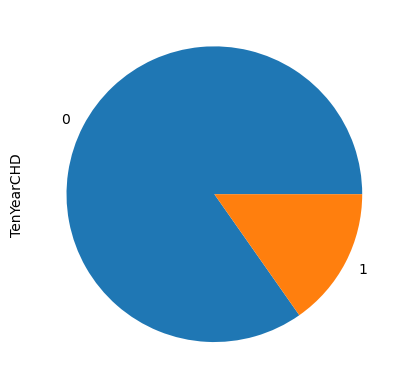

In [6]:
# value_counts().plot(kind='pie'):  hacer conteo de clases y plot tipo 'pie'
heart_df['TenYearCHD'].value_counts().plot(kind='pie')

## Descripción de Variables

Cada atributo es un factor potencial de riesgo. Existen factores demográficos, conductuales y médicos.

- Demográfico:

    - male: masculino (1) o femenino (0); (Nominal)

    - age: edad del paciente; (Continuo: aunque las edades registradas se han truncado a números enteros, el concepto de edad es continuo)

- Comportacional:

    - currentSmoker: si el paciente es o no fumador actual (nominal)

    - cigsPerDay: la cantidad de cigarrillos que la persona fumó en promedio en un día (se puede considerar continuo ya que uno puede tener cualquier cantidad de cigarrillos, incluso medio cigarrillo).

- Historia médica:

    - BPMeds: si el paciente estaba o no tomando medicación para la presión arterial (nominal)

    - prevalentStroke: si el paciente había tenido previamente un accidente cerebrovascular o no (nominal)

    - prevalentHyp: si el paciente era hipertenso (nominal)

    - diabetes: si el paciente tenía diabetes o no (nominal)

- Estado Médico actual:

    - totChol: nivel de colesterol total (continuo)

    - sysBP: presión arterial sistólica (continua)

    - diaBP: presión arterial diastólica (continua)

    - IMC: índice de masa corporal (continuo)

    - heartRate: frecuencia cardíaca (continua: en la investigación médica, variables como la frecuencia cardíaca, aunque de hecho son discretas, se consideran continuas debido a la gran cantidad de valores posibles).

    - glucose: nivel de glucosa (continuo)

- **Variable a Predecir**

    - TenYearCHD: Riesgo de padecer enfermedad coronaria 10 años en el futuro (binario: "1", significa "Sí", "0" significa "No")

In [7]:
# establecer x variables, y dependiente(variable) a predecir
x = heart_df.iloc[:,:-1]
y = heart_df.iloc[:,-1]
x

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4231,1,58,0,0.0,0.0,0,1,0,187.0,141.0,81.0,24.96,80.0,81.0
4232,1,68,0,0.0,0.0,0,1,0,176.0,168.0,97.0,23.14,60.0,79.0
4233,1,50,1,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,86.0
4234,1,51,1,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.0


In [10]:
y

0       0
1       0
2       0
3       1
4       0
       ..
4231    0
4232    1
4233    1
4234    0
4237    0
Name: TenYearCHD, Length: 3749, dtype: int64

# Tratamiento de datos desbalanceados

Crear nueva base con técnicas de tratamiento de datos desbalanceados para tratar el desbalance en la variable y binaria a clasificar.
Existen varias técnicas de desbalanceo de clases: undersampling, oversampling, KNN, entre otras.


<Axes: ylabel='TenYearCHD'>

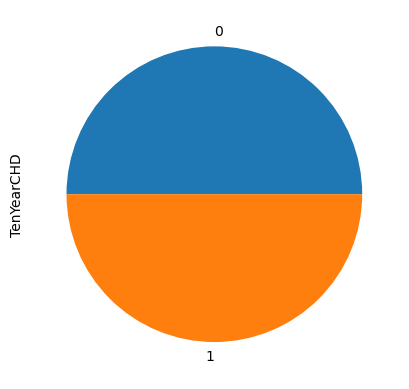

In [11]:
# crear nueva base
# SMOTE() crear clase que hacer oversampling
sm = SMOTE(random_state = None, n_jobs=-1)

# sm.fit_resample(X,Y)  crear nueva base con oversampling 
x_balance,y_balance = sm.fit_resample(x, y)
x_balance = pd.DataFrame(x_balance, columns = x.columns)

x_balance

# value_counts().plot(kind='pie'):  hacer conteo de clases y plot tipo 'pie'
y_balance.value_counts().plot(kind='pie')



In [12]:
# dividir base en train-set y test-set
x_train,x_test,y_train,y_test=train_test_split(x_balance,y_balance,test_size=.20,random_state=22)
x_train

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
3080,1,54,1,3.000000,0.000000,0,0,0,173.000000,121.000000,79.000000,26.210000,75.000000,68.000000
4738,0,48,0,4.577416,0.000000,0,0,0,288.882577,128.338067,78.000000,23.844205,70.136127,97.661933
3857,0,62,0,0.000000,0.000000,0,0,0,304.460950,144.603369,83.023737,28.012297,59.810107,75.189893
886,1,39,0,0.000000,0.000000,0,0,0,247.000000,113.000000,80.000000,28.590000,80.000000,82.000000
4120,0,38,1,24.700732,0.000000,0,0,0,184.652552,123.410220,79.880293,20.724102,65.299268,70.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5478,0,49,0,0.000000,0.292171,0,1,0,271.786115,178.168685,104.359970,25.097288,74.707829,80.539143
356,0,47,1,3.000000,0.000000,0,0,0,155.000000,122.500000,77.500000,21.340000,65.000000,78.000000
4908,0,53,0,2.221602,0.000000,0,0,0,245.987379,115.765777,75.753155,25.627937,66.727913,74.765777
6276,1,44,1,20.000000,0.000000,0,0,0,190.088799,132.441257,85.514343,22.301345,57.793715,78.514343


In [14]:
# crear escalador MinMaxScaler() sobre los predictores X para train-set y test-set
scaler = MinMaxScaler() # Utilice un MinMaxScaler #
x_train = scaler.fit_transform(x_train) # Aplique el Escalamiento (función fit_transform) # 
x_test =  scaler.fit_transform(x_test) # Aplique el Escalamiento (función fit_transform) #

type(x_train)

numpy.ndarray

## Parte 1

A continuación, debe utilizar la función `LogisticRegression` de SciKit-Learn para obtener un primer modelo de regresión logística y calcular su precisión a partir de la función `accuracy_score`.

Obtenga resultados sobre los datos de entrenamiento y los datos de prueba. Concluya al respecto.

Precisión inicial: 0.6876475216365067
Accuracy 0.68765
Precision 0.65267
Sensitivity/Recall:TPR 0.80534
Balanced Accuracy 0.68737
F1 0.72101
     0    1
0  361  273
1  124  513


<Axes: >

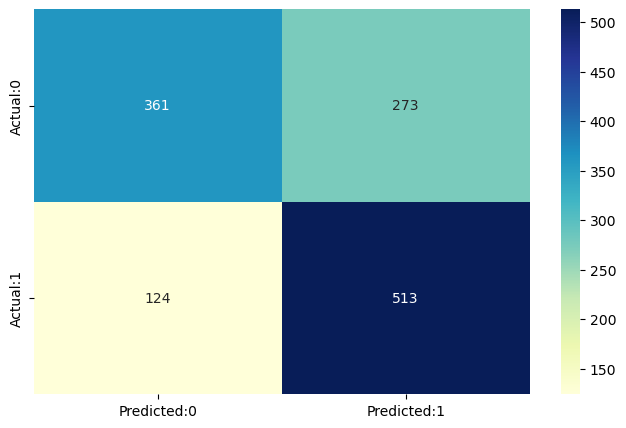

In [15]:
# crear modelo de regresion logistica
logreg = LogisticRegression()# Modelo de Regresión Logística #

# ajustar el modelo para encontrar los pesos
logreg.fit(x_train, y_train) # Entrenamiento sobre los Datos #

# obtener las predicciones de clase
y_pred = logreg.predict(x_test) # Predicción de Etiquetas #

print(f'Precisión inicial: {logreg.score(x_test, y_test)}')


# calcular matriz de confusion

confusion = confusion_matrix(y_test, y_pred)


# calcular metricas de evaluacion
print(f'Accuracy {round(accuracy_score(y_test, y_pred),5)}')
print(f'Precision {round(precision_score(y_test, y_pred),5)}')
print(f'Sensitivity/Recall:TPR {round(recall_score(y_test, y_pred),5)}')
#print(f'Specificity:TNR {round(spec,5)}')
print(f'Balanced Accuracy {round(balanced_accuracy_score(y_test, y_pred),5)}')
print(f'F1 {round(f1_score(y_test, y_pred),5)}')
    
# creara DataFrame de matriz de Confusion para cada arquitectura
print(pd.DataFrame(confusion_matrix(y_test, y_pred)))


conf_matrix = pd.DataFrame(data=confusion,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")


### Matriz de Confusión

Como recordará, la información en este dataset no posee una distribución de clases balanceada. La matriz de confusión es una herramienta que permite analizar el comportamiento del modelo para estos datos.



Puede encontrar más información en este artículo: [Understanding Confusion Matrix](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62)

## Matriz de Confusión: metricas de evaluación en clasificación


#accuracy(score)= (TP+TN)/TOT: ratio de predicciones correctas vs. totales

#recall= TP/(TP+FN): ratio de predicciones correctas de clases positivas
#recall is a good measure to determine, when high cost associated with False Negative.

#precision/sensibilidad= TP/(TP+FP): ratio de TP vs. los totales positivos, cuantos predecidos positivos son realmente positivos
#precision is a good measure to determine, when the costs of False Positive is high

#F-measure: (2*recall*precision)/(recall+precision): medición de precision(acc) y recall al mismo tiempo, penaliza los valores extremos
#F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall AND 
#there is an uneven class distribution (large number of Actual Negatives).

#confusion_matrix(y_test,y_pred): la matriz de confusión se calcula entre
#las observaciones del test-set yi y el vector de prediciones yi^

<Axes: >

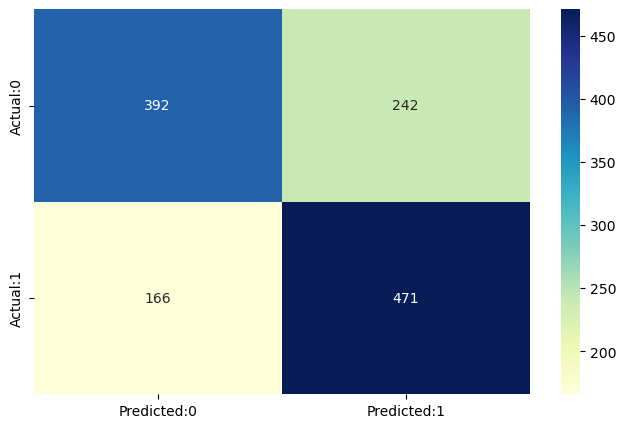

In [27]:
# crear matriz de confusión: métricas de evaluacion en clasificación 
cm = confusion_matrix(y_test,y_pred)
conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

### Tratamiento de Datos Desbalanceados

En casos de estudio como identificación de tendencias patológicas, es común tener datos desbalanceados, o en los cuales la gravedad de cometer [errores tipo I o tipo II](https://www.simplypsychology.org/type_I_and_type_II_errors.html) son bastante diferentes. En muchos casos, se puede preferir cometer cierto tipo de error sobre el otro. Para trabajar con estos problemas, se suele preferir sacrificar algo de [precisión](https://developers.google.com/machine-learning/crash-course/classification/accuracy) del modelo, a cambio de una mejora en términos prácticos.

Este proceso se realiza a partir de la modificación del umbral a partir del cual se decide si un dato pertenece a una clase u otra. Utilice la función `binarize` para obtener valores de `0` ó `1` según las probabilidades de las predicciones realizadas utilizando la función `model.predict_proba`.

Algunas métricas utilizadas para interpretar el rendimiento del modelo son las siguientes:

- F1Score
- TP Rate / Recall / Sensitividad
- TN Rate / Especificidad

Puede encontrar más información sobre estas métricas en los artículos:
- [Accuracy, Precision, Recall or F1?](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9)
- [Sensitivity Vs Specificity In Data Science](https://medium.com/fintechexplained/sensitivity-vs-specificity-in-data-science-2f673039dbd1)

In [28]:
from sklearn.preprocessing import binarize

# crear vector(array) que tiene el umbral de probabilidad para definir la pertenencia de clase
umbrales = np.linspace(0,1,20) #Vector que Contiene los Umbrales a Analizar #

# itera sobre los umbrales
for umbral in umbrales:
    cm2 = 0
    y_pred_prob_yes = logreg.predict_proba(x_test)# Utilice la función predict_proba para calcular las probabilidades de pertenecer a la Clase 1 #
    
    # convierte el vector de probabilidades de pertenencia, a clases 0 y 1 
    y_pred2 = binarize(y_pred_prob_yes, threshold= umbral)# Utilice la función binarize para convertir las probabilidades a clases 0 y 1 #
    
    # crear matriz de confusión
    cm2 = confusion_matrix(y_test,y_pred2[:,1])
    
    # métricas de evaluación en función del umbral de probabilidad de pertenencia
    print(f'''->Para un umbral de {round(umbral,4)} tenemos esta matriz de confusión:
{cm2}
Con {cm2[0,0]+cm2[1,1]} predicciones correctas y {cm2[1,0]} falsos positivos.
Sensitividad/Recall: {round(cm2[1,1]/(float(cm2[1,1]+cm2[1,0])), 4)} Especificidad: {round(cm2[0,0]/(float(cm2[0,0]+cm2[0,1])), 4)}\n''')

umbrales

->Para un umbral de 0.0 tenemos esta matriz de confusión:
[[  0 634]
 [  0 637]]
Con 637 predicciones correctas y 0 falsos positivos.
Sensitividad/Recall: 1.0 Especificidad: 0.0

->Para un umbral de 0.0526 tenemos esta matriz de confusión:
[[  1 633]
 [  1 636]]
Con 637 predicciones correctas y 1 falsos positivos.
Sensitividad/Recall: 0.9984 Especificidad: 0.0016

->Para un umbral de 0.1053 tenemos esta matriz de confusión:
[[ 14 620]
 [  2 635]]
Con 649 predicciones correctas y 2 falsos positivos.
Sensitividad/Recall: 0.9969 Especificidad: 0.0221

->Para un umbral de 0.1579 tenemos esta matriz de confusión:
[[ 51 583]
 [  3 634]]
Con 685 predicciones correctas y 3 falsos positivos.
Sensitividad/Recall: 0.9953 Especificidad: 0.0804

->Para un umbral de 0.2105 tenemos esta matriz de confusión:
[[103 531]
 [ 15 622]]
Con 725 predicciones correctas y 15 falsos positivos.
Sensitividad/Recall: 0.9765 Especificidad: 0.1625

->Para un umbral de 0.2632 tenemos esta matriz de confusión:
[[152 4

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

Por otra parte, un criterio que facilita el visualizar este trade-off se conoce como la Curva ROC, en donde se ubican múltiples puntos para distintos valores del umbral de clasificación. Puede leer el artículo a continuación para una explicación más detallada:
- Curva ROC: [Understanding AUC - ROC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

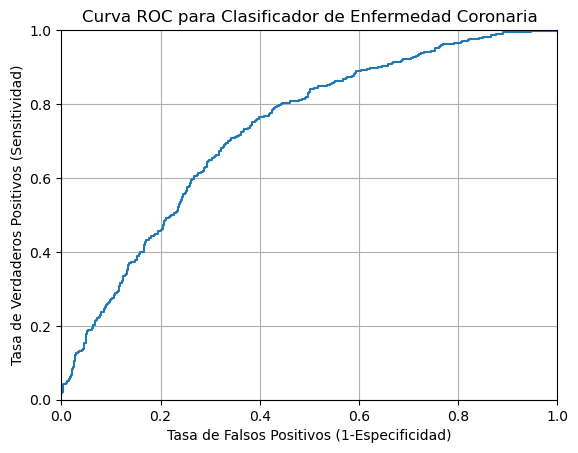

In [29]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_yes[:,1])
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC para Clasificador de Enfermedad Coronaria')
plt.xlabel('Tasa de Falsos Positivos (1-Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensitividad)')
plt.grid(True)

Observe la gráfica, y teniendo en cuenta los resultados concluya sobre la proporción que se puede considerar más adecuada en este contexto.

*Se quiere maximizar el area bajo la curva. para esta aplicación se quiere maximizar la tasa de TP (sensitividad/recall) a costo de precisión(acc) o tasa de FP

## Parte 2

Ahora usted debe desarrollar su propia implementación del método Descenso de Gradiente estocástico para un modelo de regresión logística. Realice el entrenamiento a partir del 80% de los datos. Al final del entrenamiento, en la lista errores se deben tener los valores de la función de error para cada iteración y así poder observar el progreso gráficamente.

In [30]:
# cargar base heartDisease.  pd.read_csv()
heart_df=pd.read_csv("heartDisease/framingham.csv")

# limpiar  la base - data mining
# dropna(axis=0 filas, inplace=True),  dropear filas con observaciones NA
heart_df.dropna(axis=0,inplace=True)
heart_df.head()



,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [31]:
# codificacion

# crear variables dicotomas 0-1 para todas las variables categoricas
# ** para esta base todas las variables son continuas, entonces no hay variables discretas(categoricas) que dummyficar 
heart_df_dumm = pd.get_dummies(heart_df, drop_first=True)

# escalar base de datos (escalar variables)
# crear escalador Robusto
scaler = RobustScaler() # Escalador Robusto de X (train-set y test-set) #

# escalar toda la base con el escalador RobustScaler() 
df_scaled = scaler.fit_transform(heart_df_dumm)
df_scaled = pd.DataFrame(df_scaled, columns = heart_df_dumm.columns)

df_scaled

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1.0,-0.714286,0.0,0.00,0.0,0.0,0.0,0.0,-0.672414,-0.814815,-0.800000,0.313883,0.357143,-0.0625,0.0
1,0.0,-0.214286,0.0,0.00,0.0,0.0,0.0,0.0,0.275862,-0.259259,-0.066667,0.668008,1.428571,-0.1250,0.0
2,1.0,-0.071429,1.0,1.00,0.0,0.0,0.0,0.0,0.189655,-0.018519,-0.133333,-0.014085,0.000000,-0.5000,0.0
3,0.0,0.857143,1.0,1.50,0.0,0.0,1.0,0.0,-0.155172,0.814815,0.866667,0.637827,-0.714286,1.5625,1.0
4,0.0,-0.214286,1.0,1.15,0.0,0.0,0.0,0.0,0.879310,0.074074,0.133333,-0.464789,0.714286,0.4375,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3744,1.0,0.642857,0.0,0.00,0.0,0.0,1.0,0.0,-0.810345,0.481481,-0.066667,-0.090543,0.357143,0.1875,0.0
3745,1.0,1.357143,0.0,0.00,0.0,0.0,1.0,0.0,-1.000000,1.481481,1.000000,-0.456740,-1.071429,0.0625,1.0
3746,1.0,0.071429,1.0,0.05,0.0,0.0,1.0,0.0,1.362069,1.888889,0.666667,0.112676,-0.642857,0.5000,1.0
3747,1.0,0.142857,1.0,2.15,0.0,0.0,0.0,0.0,-0.465517,-0.055556,-0.133333,-1.146881,-0.714286,-0.6250,0.0


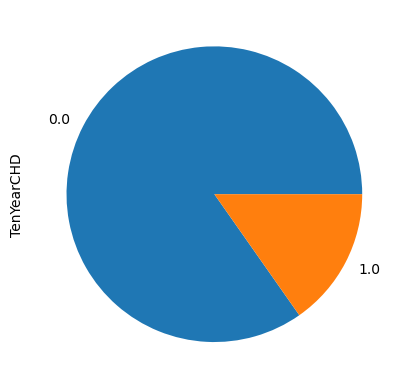

In [32]:
# proporcion de clase

# value_counts().plot(kind='pie'):  hacer conteo de clases y plot tipo 'pie'
df_scaled['TenYearCHD'].value_counts().plot(kind='pie')

# establecer x variables, y observación(variable) a predecir
x = df_scaled.drop(['TenYearCHD'], axis=1) # x
y = df_scaled['TenYearCHD'] # y[0-1]: TenYearCHD: Riesgo de padecer enfermedad coronaria 10 años en el futuro categorica(dicotoma)


,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
3080,1.00000,0.357143,1.0,0.150000,0.000000,0.0,0.0,0.000000,-1.051724,-0.259259,-0.200000,0.160966,0.000000,-0.625000
4738,1.00000,-0.613011,1.0,1.398725,0.000000,0.0,0.0,0.000000,0.441951,-0.351616,-0.372993,-0.516493,0.001821,-0.036385
3857,0.00000,-0.090986,1.0,1.181547,0.000000,0.0,0.0,0.726189,1.206897,-0.881834,-0.932936,0.260370,1.492346,-0.595981
886,1.00000,-0.714286,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.224138,-0.555556,-0.133333,0.639839,0.357143,0.250000
4120,1.00000,0.768869,1.0,1.000000,0.000000,0.0,0.0,0.000000,0.448276,-0.031621,-0.630713,-0.031670,-0.714286,-0.148194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5478,0.70862,0.253079,1.0,1.354310,0.000000,0.0,0.0,0.000000,1.656659,-0.074809,-0.455632,0.215503,1.113054,-0.981789
356,0.00000,-0.142857,1.0,0.150000,0.000000,0.0,0.0,0.000000,-1.362069,-0.203704,-0.300000,-0.818913,-0.714286,0.000000
4908,1.00000,0.920579,1.0,1.000000,0.805507,0.0,1.0,0.000000,0.029170,1.838465,1.050029,-1.207240,1.359110,-0.112844
6276,1.00000,1.103661,1.0,2.716807,0.000000,0.0,1.0,0.000000,0.319038,1.566044,1.105602,-0.349526,0.048679,0.027101


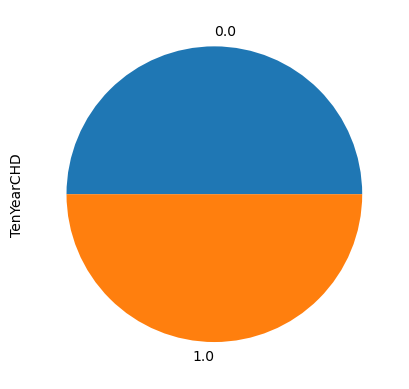

In [33]:
# tratamiento de clase desbalanceados

# crear nueva base
# SMOTE() crear clase que hacer oversampling
sm1 = SMOTE(random_state = None, n_jobs=-1)

# sm.fit_resample(X,Y)  crear nueva base con oversampling 
x_balance,y_balance = sm1.fit_resample(x, y)
x_balance = pd.DataFrame(x_balance, columns = x.columns)


y_balance.value_counts().plot(kind='pie')


# dividir train-set y test-set
x_train,x_test,y_train,y_test=train_test_split(x_balance,y_balance,test_size=.20,random_state=22)


x_train
# crear escalador MinMaxScaler() sobre las observaciones de la base X (los predictores X) para X train-set y  X test-set
#scaler = RobustScaler() # Escalador Robusto de X (train-set y test-set) #
#x_train = scaler.fit_transform(x_train) # Aplique el Escalamiento (función fit_transform) # 
#x_test =  scaler.fit_transform(x_test) # Aplique el Escalamiento (función fit_transform) #

In [34]:
# crear seed para replicabilidad   
np.random.seed(22)

# crear el predictor cte=1 
x_train_array = np.c_[np.ones(x_train.values.shape[0]), x_train.values]
y_train_array = y_train.values
x_test_array = np.c_[np.ones(y_test.values.shape[0]), y_test.values]
y_test_array = y_test.values

print(x_train_array.shape)
x_train_array

(5083, 15)


array([[ 1.        ,  1.        ,  0.35714286, ...,  0.16096579,
         0.        , -0.625     ],
       [ 1.        ,  1.        , -0.61301087, ..., -0.51649273,
         0.00182121, -0.03638451],
       [ 1.        ,  0.        , -0.09098649, ...,  0.26036969,
         1.49234557, -0.59598142],
       ...,
       [ 1.        ,  1.        ,  0.92057935, ..., -1.20723994,
         1.35910962, -0.11284418],
       [ 1.        ,  1.        ,  1.10366145, ..., -0.34952571,
         0.04867949,  0.02710084],
       [ 1.        ,  1.        , -0.07142857, ..., -0.09255533,
         0.        , -0.0625    ]])

In [35]:
# inicializar w: vector de los estimadores/predictores del modelo
# w0 es el vector de estimadores inicial aleatorio que solo se usa en la primera iteración
w0 = np.random.rand(x_train_array.shape[1]) # Inicialización de w #w = w0.copy()
# w vector de estimadores/predictores que se va a actualizar
w= w0.copy()
w_ant=w0


# variables de control sobre el algoritmo 
# Inicialización de criterio de parada (al disminuir el valor de eps, se aumenta la precisión y el tiempo de procesamiento)
eps = 1e-3 # epsilon que es el umbral del error para asegurar convergencia
error0 = float('inf') # se inicializa el error
dif = float('inf') # se inicializa la diferencia de los errores en 100 (default)


# calcular la tasa de aprendizaje optima
xtx = np.dot(x_train_array.transpose(), x_train_array)
vp = np.linalg.eigvals(xtx)
max_vp = np.sqrt(max(vp))
tasa0 = (2/max_vp)-0.001


# tasas de aprendizaje
tasas = np.linspace(0,0.5,100) # Defina un vector que contenga las tasas de aprendizaje que desea probar #
# umbrales que se utilizan para calcular la probabilidad clasificacion
umbrales = np.linspace(0,1,50) 


# lista de errores para evaluar el aprendizaje del algoritmo
errores = [] # agregar los errores a la lista en cada iteración
errores.append(error0)

# numero de iteraciones en las que converge el algoritmo
n = 0

# definir la función de activación: para el caso de regresión logistica
# la función de activación es la función sigmoide (regresión logística)
# la función sigmoide(sigma) es la probabilidad dada por el modelo con parámetros w
# que la observacion xi pertenezca a la clase k (k=1)


# el gradiente en la regresion logistica es la función sigmoide (probabilidad de pertenencia) de xi con parámetros/estimadores wi MLE  

# parámetros: wi predictores/estimadores actuales, xi x actual el punto estocástico
def sigma(w,x):
    wtx=np.dot(w.transpose(),x)
    res_sigmoid = 1/(1+np.exp(-wtx)) # Salida de la función sigmoide #
    return res_sigmoid

# valores de prueba
#dif = 10
#eps=0


# crear listas de metricas de evaluacion
acc_list = []
prec_list = []
rec_list = []
f1_list = []
bal_list = []

# parametros de validacion cruzada a sintonizar
tasa_opt=float('inf') # tasa de aprendizaje optima
c_opt = 0 # umbral de decision optimo
n_opt=float('inf') # numero de iteraciones para convergencia
dif_opt = float('inf')
w_opt = w0

# metricas de evaluacion optimas
acc_opt = 0
prec_opt = 0
rec_opt = 0
f1_opt = 0
bal_opt = 0

        



# algoritmo gradiente (descendente??) estocastico
# encontrar el w_opt que maximice la función de max. versimilitud sigma
# ajustar wi a w_opt de parámetros/estimadores

# itera sobre las tasas de aprendizaje
for tasa in tasas:
    # itera sobre el umbral de cálculo de probabilidad
    for c in umbrales:
        
        # estimar vector w óptimo
        # criterio de parada cuando diferencia de errores en iteracion (wk - wk-1)   es menor que eps
        
        ### Algoritmo de Gradiente Descendente para converger a w  (mini-batch estocástico = 1)
        while dif > eps:
            # escoger el punto aleatorio
            
            # punto de mini batch estocástico extremo n =1
            i = np.random.randint(x_train_array.shape[0])
            xActual = x_train_array[i] #X_train_array[i]
            yActual = y_train_array[i]
        
            # calculo del gradiente, aplicando la funcion logistica sigmoide de activación
            gradiente_log = sigma(w,xActual)   
        
            # error: yi-gradiente_log(sigmoide(w,xi))
            error = yActual - gradiente_log
            errores.append(error)
        
            # calcular/actualizar el vector de estimadores/predictores
            w = w_ant+tasa*error*xActual
        
            # calcular la diferencia de errores para comparar con umbral de convergencia eps
            dif = np.abs(errores[-1]-errores[-2]) 
            w_ant = w
            n+=1
            #eps+=1
            
            
        
        ### Evaluar el vector w de convergencia de Gradiente Descendente para realizar las predicciones
        x_test_array = np.c_[np.ones(x_test.values.shape[0]), x_test.values]
        y_test_array = y_test.values   
        
        # crear vector de y_predict de predicciones
        y_predict = np.zeros(len(x_test_array))
        #c = 0.5 # umbral de Probabilidad de Bernoulli
        
        # recorre vector y_predict de predicciones
        # predice para la etiqueta de x_test_array[i]: clase k[0-1]
        # calcula la función sigma de verosimilitud de probabilidad de pertenencia
        
        
        # recorre el vector x-test sobre el cual se va a realizar predicciones de etiquetas binarias
        # con el calculo de funcion sigma de w ajustado y x_test[i] para un c dado
        for i in range(0, len(x_test_array)):
            # calculo de probabilidad  (MLE) de x-test[i] con vector w de pesos
            prob_sigma = sigma(w, x_test_array[i])
            if prob_sigma>c:
                y_predict[i]=1
            else:
                y_predict[i]=0
                
                
        # crear matriz de confusión: métricas de evaluacion en clasificación 
        #cm = confusion_matrix(y_test,y_predict)   
        #conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
        #plt.figure(figsize = (8,5))
        #sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
        
        
        # calcular métricas de evaluación
        acc = accuracy_score(y_test,y_predict)   
        prec = precision_score(y_test,y_predict)
        rec = recall_score(y_test,y_predict)
        f1 = f1_score(y_test,y_predict)
        bal = balanced_accuracy_score(y_test,y_predict)
        
        # agregar metricas de evaluacion a listas
        acc_list.append(acc) 
        prec_list.append(prec)
        rec_list.append(rec)
        f1_list.append(f1)
        bal_list.append(bal)
            
        print(f'Accuracy {round(acc,5)}')
        print(f'Precision {round(prec,5)}')
        print(f'Sensitivity/Recall:TPR {round(rec,5)}')
        #print(f'Specificity:TNR {round(spec,5)}')
        print(f'Balanced Accuracy {round(bal,5)}')
        print(f'F1 {round(f1,5)} \n')
            
            
        # scoring: dependiendo de la métrica de evaluacion que se quiere maximizar
        if acc > acc_opt:
            acc_opt = acc
            
            # actualizar hiper parámetros óptimos 
            tasa_opt = tasa
            c_opt = c
            n_opt = n
            dif_opt = dif
            w_opt = w
            
            # actualizar métricas de evaluación óptimas
            prec_opt = prec
            rec_opt = rec
            f1_opt = f1
            bal_opt = bal
            
            
data_metricas = {'Accuracy':acc_opt,'Precision':prec_opt, 'Recall':rec_opt, 'F1 Score':f1_score, 'Balanced Accuracy': bal_opt}
data_hp = {'Tasa de Aprendizaje':tasa_opt, 'Umbral de Decisión':c_opt}


df_hp = pd.DataFrame([[key, data_hp[key]] for key in data_hp.keys()], columns=['Hiperparámetros ', 'Valor'])
df_metricas = pd.DataFrame([[key, data_metricas[key]] for key in data_metricas.keys()], columns=['Mejores Metricas ', 'Valor'])



print("El número de iteraciones en las que convergió el algorimto de Gradiente Descendente Estocástico es: "+str(n_opt)) 
print("La diferencia de errores en la última iteración es: "+ str(dif_opt))
print("El vector de predictores/estimadores w_opt que mejor ajusta el modelo es: " + str(w_opt))

print("El mejor modelo se obtiene con los hiperparámetros: ")
print(data_hp)

print("Las métricas de evaluación del mejor modelo son: ")
print(df_metricas)

    


Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.5

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.49882
Precision 0.0
Sensitivity/Recall:TPR 0.0
Balanced Accuracy 0.5
F1 0.0 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accu

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.49882
Precision 0.0
Sensitivity/Recall:TPR 0.0
Balanced Accuracy 0.5
F1 0.0 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.5

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accu

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accu

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.49882
Precision 0.0
Sensitivity/Recall:TPR 0.0
Balanced Accuracy 0.5
F1 0.0 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
Balanced Accuracy 0.53945
F1 0.68364 

Accuracy 0.54445
Precision 0.52425
Sensitivity/Recall:TPR 0.9843
Balanced Accuracy 0.54341
F1 0.68412 

Accuracy 0.54524
Precision 0.52485
Sensitivity/Recall:TPR 0.97802
Balanced Accuracy 0.54422
F1 0.68311 

Accuracy 0.54603
Precision 0.52542
Sensitivity/Recall:TPR 0.

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
Balanced Accuracy 0.53945
F1 0.68364 

Accuracy 0.54445
Precision 0.52425
Sensitivity/Recall:TPR 0.9843
Balanced Accuracy 0.54341
F1 0.68412 

Accuracy 0.54524
Precision 0.52485
Sensitivity/Recall:TPR 0.97802
Balanced Accuracy 0.54422
F1 0.68311 

Accuracy 0.54603
Precision 0.52542
Sensitivity/Recall:TPR 0.

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
Balanced Accuracy 0.53945
F1 0.68364 

Accuracy 0.54445
Precision 0.52425
Sensitivity/Recall:TPR 0.984

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.5

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.49882
Precision 0.0
Sensitivity/Recall:TPR 0.0
Balanced Accuracy 0.5
F1 0.0 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accu

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
Balanced Accuracy 0.53945
F1 0.68364 

Accuracy 0.54445
Precision 0.52425
Sensitivity/Recall:TPR 0.984

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.49882
Precision 0.0
Sensitivity/Recall:TPR 0.0
Balanced Accuracy 0.5
F1 0.0 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.49882
Precision 0.0
Sensitivity/Recall:TPR 0.0
Balanced Accuracy 0.5
F1 0.0 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.49882
Precision 0.0
Sensitivity/Recall:TPR 0.0
Balanced Accuracy 0.5
F1 0.0 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balan

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.49882
Precision 0.0
Sensitivity/Recall:TPR 0.0
Balanced Accuracy 0.5
F1 0.0 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
Balanced Accuracy 0.53945
F1 0.68364 

Accuracy 0.54445
Precision 0.52425
Sensitivity/Recall:TPR 0.9843
Balanced Accuracy 0.54341
F1 0.68412 

Accuracy 0.54524
Precision 0.52485
Sensitivity/Recall:TPR 0.97802
Balanced Accuracy 0.54422
F1 0.68311 

Accuracy 0.54603
Precision 0.52542
Sensitivity/Recall:TPR 0.

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balan

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accu

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.5

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
Balanced Accuracy 0.53945
F1 0.68364 

Accuracy 0.54445
Precision 0.52425
Sensitivity/Recall:TPR 0.9843
Balanced Accuracy 0.54341
F1 0.68412 

Accuracy 0.54524
Precision 0.52485
Sensitivity/Recall:TPR 0.

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accu

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
Balanced Accuracy 0.53945
F1 0.68364 

Accuracy 0.54445
Precision 0.52425
Sensitivity/Recall:TPR 0.9843
Balanced Accuracy 0.54341
F1 0.68412 

Accuracy 0.54524
Precision 0.52485
Sensitivity/Recall:TPR 0.97802
Balanced Accuracy 0.54422
F1 0.68311 

Accuracy 0.54603
Precision 0.52542
Sensitivity/Recall:TPR 0.

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
B

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
Balanced Accuracy 0.53945
F1 0.68364 

Accuracy 0.54445
Precision 0.52425
Sensitivity/Recall:TPR 0.9843
Balanced Accuracy 0.54341
F1 0.68412 

Accuracy 0.54524
Precision 0.52485
Sensitivity/Recall:TPR 0.97802
Balanced Accuracy 0.54422
F1 0.68311 

Accuracy 0.54603
Precision 0.52542
Sensitivity/Recall:TPR 0.

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
Balanced Accuracy 0.53945
F1 0.68364 

Accuracy 0.54445
Precision 0.52425
Sensitivity/Recall:TPR 0.9843
Balanced Accuracy 0.54341
F1 0.68412 

Accuracy 0.54524
Precision 0.52485
Sensitivity/Recall:TPR 0.97802
Balanced Accuracy 0.54422
F1 0.68311 

Accuracy 0.54603
Precision 0.52542
Sensitivity/Recall:TPR 0.97331
Balanced Accuracy 0.54502
F1 0.68244 

Accuracy 0.54996
Precision 0.52775
Sensitivity/Recall:TPR 0.

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
Balanced Accuracy 0.53945
F1 0.68364 

Accuracy 0.54445
Precision 0.52425
Sensitivity/Recall:TPR 0.984

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.49882
Precision 0.0
Sensitivity/Recall:TPR 0.0
Balanced Accuracy 0.5
F1 0.0 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.49882
Precision 0.0
Sensitivity/Recall:TPR 0.0
Balanced Accuracy 0.5
F1 0.0 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
Balanced Accuracy 0.53945
F1 0.68364 

Accuracy 0.54445
Precision 0.52425
Sensitivity/Recall:TPR 0.9843
Balanced Accuracy 0.54341
F1 0.68412 

Accuracy 0.54524
Precision 0.52485
Sensitivity/Recall:TPR 0.

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
Balanced Accuracy 0.53945
F1 0.68364 

Accuracy 0.54445
Precision 0.52425
Sensitivity/Recall:TPR 0.984

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.49882
Precision 0.0
Sensitivity/Recall:TPR 0.0
Balanced Accuracy 0.5
F1 0.0 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
B

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
Balanced Accuracy 0.53945
F1 0.68364 

Accuracy 0.54445
Precision 0.52425
Sensitivity/Recall:TPR 0.9843
Balanced Accuracy 0.54341
F1 0.68412 

Accuracy 0.54524
Precision 0.52485
Sensitivity/Recall:TPR 0.97802
Balanced Accuracy 0.54422
F1 0.68311 

Accuracy 0.54603
Precision 0.52542
Sensitivity/Recall:TPR 0.97331
Balanced Accuracy 0.54502
F1 0.68244 

Accuracy 0.54996
Precision 0.52775
Sensitivity/Recall:TPR 0.

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.49882
Precision 0.0
Sensitivity/Recall:TPR 0.0
Balanced Accuracy 0.5
F1 0.0 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balan

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.49882
Precision 0.0
Sensitivity/Recall:TPR 0.0
Balanced Accuracy 0.5
F1 0.0 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.49882
Precision 0.0
Sensitivity/Recall:TPR 0.0
Balanced Accuracy 0.5
F1 0.0 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.49882
Precision 0.0
Sensitivity/Recall:TPR 0.0
Balanced Accuracy 0.5
F1 0.0 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.49882
Precision 0.0
Sensitivity/Recall:TPR 0.0
Balanced Accuracy 0.5
F1 0.0 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accu

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
Balanced Accuracy 0.53945
F1 0.68364 

Accuracy 0.54445
Precision 0.52425
Sensitivity/Recall:TPR 0.9843
Balanced Accuracy 0.54341
F1 0.68412 

Accuracy 0.54524
Precision 0.52485
Sensitivity/Recall:TPR 0.97802
Balanced Accuracy 0.54422
F1 0.68311 

Accuracy 0.54603
Precision 0.52542
Sensitivity/Recall:TPR 0.

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
Balanced Accuracy 0.53945
F1 0.68364 

Accuracy 0.54445
Precision 0.52425
Sensitivity/Recall:TPR 0.984

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accu

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.49882
Precision 0.0
Sensitivity/Recall:TPR 0.0
Balanced Accuracy 0.5
F1 0.0 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
B

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
B

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
Balanced Accuracy 0.53945
F1 0.68364 

Accuracy 0.54445
Precision 0.52425
Sensitivity/Recall:TPR 0.984

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
Balanced Accuracy 0.53945
F1 0.68364 

Accuracy 0.54445
Precision 0.52425
Sensitivity/Recall:TPR 0.984

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
Balanced Accuracy 0.53945
F1 0.68364 

Accuracy 0.54445
Precision 0.52425
Sensitivity/Recall:TPR 0.9843
Balanced Accuracy 0.54341
F1 0.68412 

Accuracy 0.54524
Precision 0.52485
Sensitivity/Recall:TPR 0.97802
Balanced Accuracy 0.54422
F1 0.68311 

Accuracy 0.54603
Precision 0.52542
Sensitivity/Recall:TPR 0.

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balan

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balan

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
Balanced Accuracy 0.53945
F1 0.68364 

Accuracy 0.54445
Precision 0.52425
Sensitivity/Recall:TPR 0.9843
Balanced Accuracy 0.54341
F1 0.68412 

Accuracy 0.54524
Precision 0.52485
Sensitivity/Recall:TPR 0.97802
Balanced Accuracy 0.54422
F1 0.68311 

Accuracy 0.54603
Precision 0.52542
Sensitivity/Recall:TPR 0.

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
Balanced Accuracy 0.53945
F1 0.68364 

Accuracy 0.54445
Precision 0.52425
Sensitivity/Recall:TPR 0.984

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
Balanced Accuracy 0.53945
F1 0.68364 

Accuracy 0.54445
Precision 0.52425
Sensitivity/Recall:TPR 0.984

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balan

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.5

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accu

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balan

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accu

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balan

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accu

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.49882
Precision 0.0
Sensitivity/Recall:TPR 0.0
Balanced Accuracy 0.5
F1 0.0 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
B

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accu

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
B

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.5

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balan

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
Balanced Accuracy 0.53945
F1 0.68364 

Accuracy 0.54445
Precision 0.52425
Sensitivity/Recall:TPR 0.9843
Balanced Accuracy 0.54341
F1 0.68412 

Accuracy 0.54524
Precision 0.52485
Sensitivity/Recall:TPR 0.97802
Balanced Accuracy 0.54422
F1 0.68311 

Accuracy 0.54603
Precision 0.52542
Sensitivity/Recall:TPR 0.97331
Balanced Accuracy 0.54502
F1 0.68244 

Accuracy 0.54996
Precision 0.52775
Sensitivity/Recall:TPR 0.

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
Balanced Accuracy 0.53945
F1 0.68364 

Accuracy 0.54445
Precision 0.52425
Sensitivity/Recall:TPR 0.984

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
Balanced Accuracy 0.53945
F1 0.68364 

Accuracy 0.54445
Precision 0.52425
Sensitivity/Recall:TPR 0.984

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balan

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
B

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
Balanced Accuracy 0.53945
F1 0.68364 

Accuracy 0.54445
Precision 0.52425
Sensitivity/Recall:TPR 0.984

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.49882
Precision 0.0
Sensitivity/Recall:TPR 0.0
Balanced Accuracy 0.5
F1 0.0 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
B

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accu

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.49882
Precision 0.0
Sensitivity/Recall:TPR 0.0
Balanced Accuracy 0.5
F1 0.0 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.49882
Precision 0.0
Sensitivity/Recall:TPR 0.0
Balanced Accuracy 0.5
F1 0.0 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.5

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.49882
Precision 0.0
Sensitivity/Recall:TPR 0.0
Balanced Accuracy 0.5
F1 0.0 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.49882
Precision 0.0
Sensitivity/Recall:TPR 0.0
Balanced Accuracy 0.5
F1 0.0 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accu

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balan

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
Balanced Accuracy 0.53945
F1 0.68364 

Accuracy 0.54445
Precision 0.52425
Sensitivity/Recall:TPR 0.984

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accu

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accu

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
Balanced Accuracy 0.53945
F1 0.68364 

Accuracy 0.54445
Precision 0.52425
Sensitivity/Recall:TPR 0.9843
Balanced Accuracy 0.54341
F1 0.68412 

Accuracy 0.54524
Precision 0.52485
Sensitivity/Recall:TPR 0.

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.49882
Precision 0.0
Sensitivity/Recall:TPR 0.0
Balanced Accuracy 0.5
F1 0.0 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50118
Precision 0.50118
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.5
F1 0.66771 

Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
B

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
Balanced Accuracy 0.53945
F1 0.68364 

Accuracy 0.54445
Precision 0.52425
Sensitivity/Recall:TPR 0.9843
Balanced Accuracy 0.54341
F1 0.68412 

Accuracy 0.54524
Precision 0.52485
Sensitivity/Recall:TPR 0.97802
Balanced Accuracy 0.54422
F1 0.68311 

Accuracy 0.54603
Precision 0.52542
Sensitivity/Recall:TPR 0.97331
Balanced Accuracy 0.54502
F1 0.68244 

Accuracy 0.54996
Precision 0.52775
Sensitivity/Recall:TPR 0.

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
Balanced Accuracy 0.53945
F1 0.68364 

Accuracy 0.54445
Precision 0.52425
Sensitivity/Recall:TPR 0.9843
Balanced Accuracy 0.54341
F1 0.68412 

Accuracy 0.54524
Precision 0.52485
Sensitivity/Recall:TPR 0.

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
Balanced Accuracy 0.53945
F1 0.68364 

Accuracy 0.54445
Precision 0.52425
Sensitivity/Recall:TPR 0.9843
Balanced Accuracy 0.54341
F1 0.68412 

Accuracy 0.54524
Precision 0.52485
Sensitivity/Recall:TPR 0.

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balanced Accuracy 0.53551
F1 0.68214 

Accuracy 0.54052
Precision 0.52192
Sensitivity/Recall:TPR 0.99058
Balanced Accuracy 0.53945
F1 0.68364 

Accuracy 0.54445
Precision 0.52425
Sensitivity/Recall:TPR 0.9843
Balanced Accuracy 0.54341
F1 0.68412 

Accuracy 0.54524
Precision 0.52485
Sensitivity/Recall:TPR 0.

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balan

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.50197
Precision 0.50157
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50079
F1 0.66807 

Accuracy 0.50433
Precision 0.50276
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50315
F1 0.66912 

Accuracy 0.50905
Precision 0.50515
Sensitivity/Recall:TPR 1.0
Balanced Accuracy 0.50789
F1 0.67123 

Accuracy 0.51062
Precision 0.50597
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.50947
F1 0.67159 

Accuracy 0.51849
Precision 0.51002
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.51735
F1 0.67516 

Accuracy 0.52242
Precision 0.51208
Sensitivity/Recall:TPR 0.99843
Balanced Accuracy 0.5213
F1 0.67696 

Accuracy 0.52793
Precision 0.515
Sensitivity/Recall:TPR 0.99686
Balanced Accuracy 0.52682
F1 0.67914 

Accuracy 0.5295
Precision 0.51589
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52841
F1 0.67918 

Accuracy 0.53108
Precision 0.51673
Sensitivity/Recall:TPR 0.99372
Balanced Accuracy 0.52998
F1 0.67991 

Accuracy 0.53659
Precision 0.51974
Sensitivity/Recall:TPR 0.99215
Balan

c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Matriz de Confusión

Observe y analice la matriz de confusión para su mejor modelo. Escriba claramente sus conclusiones.

<Axes: >

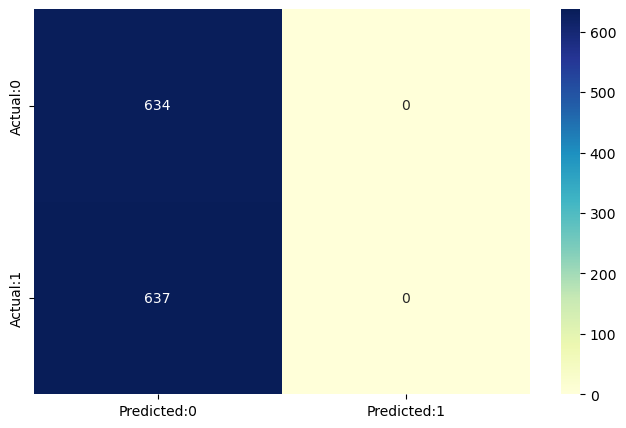

In [36]:
cm = confusion_matrix(y_test,y_predict)
conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])

plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [37]:
# calcular metricas de evaluacion
print(f'Accuracy {round(accuracy_score(y_test, y_predict),5)}')
print(f'Precision {round(precision_score(y_test, y_predict),5)}')
print(f'Sensitivity/Recall {round(recall_score(y_test, y_predict),5)}')
print(f'Balanced Accuracy {round(balanced_accuracy_score(y_test, y_predict),5)}')
print(f'F1 {round(f1_score(y_test, y_predict),5)}')

print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

Accuracy 0.49882
Precision 0.0
Sensitivity/Recall 0.0
Balanced Accuracy 0.5
F1 0.0
     0  1
0  634  0
1  637  0


c:\Users\Diego\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
